mainly looking at https://github.com/ngessert/isic2019/blob/master/models.py

# start

In [78]:
PRFX = 'Mel0626A2'
SEED = 101
ARCH = 'efficientnet-b0'
SZ = 128
EPOCHS = 10
BS = 8

FP16 = True
DEBUG = True
if DEBUG: EPOCHS=1
DEVICE = 'cpu'; PIN_MEM = (DEVICE=='cuda')

# setup

In [38]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from efficientnet_pytorch import EfficientNet

from apex import amp

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

set_seed(SEED)

In [16]:
p_cmp = '../input/siim-isic-melanoma-classification'
p_19 = '../input/andrewmvd--isic-2019'
# p_out=f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)

train,test,sample_submission = (pd.read_csv(o, nrows=100 if DEBUG else None) 
                                for o in [f'{p_cmp}/{o}.csv' 
                                          for o in ('train', 'test', 'sample_submission')])
print([o.shape for o in (train,test,sample_submission)])

train19 = pd.read_csv(f'{p_19}/ISIC_2019_Training_GroundTruth.csv', nrows=100 if DEBUG else None)
print(train19.shape)

display(train19.head(2))
display(train.head(2))

test.head(2)

[(100, 8), (100, 5), (100, 2)]
(100, 10)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity


# prep

## merge dfs

In [17]:
train['source'] = '20'
train['im_pth'] = f'{p_cmp}/jpeg/train/'+train.image_name+'.jpg'
train19['source'] = '19'
train19['target'] = train19.MEL
train19['im_pth'] = f'{p_19}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+train19.image+'.jpg'


In [18]:
cols2use=['source', 'im_pth', 'target', ]
train_all = pd.concat([train[cols2use], train19[cols2use]])
display(train_all.shape)
display(train_all.source.value_counts())
display(train_all.groupby('source').target.mean())

(200, 3)

19    100
20    100
Name: source, dtype: int64

source
19    0.19
20    0.01
Name: target, dtype: float64

## load images

In [19]:
%%time
im_pil = Image.open(train_all.im_pth.sample().values[0])

CPU times: user 2.73 ms, sys: 107 µs, total: 2.84 ms
Wall time: 5.62 ms


In [40]:
lst_im_pil = []
for im_pth in tqdm(train_all.im_pth):
    lst_im_pil.append(Image.open(im_pth))
    
### faster to preload images
# i = np.random.choice(range(len(train_all)))
# %%timeit 
# im_pil = Image.open(train_all.im_pth.values[i])
# %%timeit 
# im_pil = lst_im_pil[i]

100%|██████████| 200/200 [00:00<00:00, 3185.39it/s]


# dataset

In [41]:
class MelDataset(Dataset):
    def __init__(self, imgs, targets=None):
        self.imgs = imgs
        self.targets = targets
        self.composed = transforms.Compose([
            transforms.RandomResizedCrop(SZ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])    
    def __getitem__(self, i):
        x = self.imgs[i]
        x = self.composed(x)
        if self.targets is not None:
            y = self.targets[i]
            return x, y
        else:
            return x,
    
    def __len__(self):
        return len(self.imgs)    

In [44]:
ds_train = MelDataset(lst_im_pil, train_all.target.values)
ds_train[0][0].shape, ds_train[0][1]

(torch.Size([3, 128, 128]), 0.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


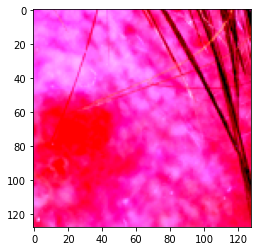

In [72]:
plt.imshow(ds_train[0][0].numpy().transpose(1,2,0));

In [80]:
dl_train = DataLoader(ds_train, batch_size=BS, shuffle=True, num_workers=4, pin_memory=PIN_MEM)
for dat in dl_train:
    x,y=dat; break

In [83]:
x.shape, y

(torch.Size([8, 3, 128, 128]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]))

In [98]:
del ds_train; gc.collect()

19672

# Model

In [99]:
mdl = EfficientNet.from_pretrained(ARCH, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [100]:
mdl(x).shape

torch.Size([8, 1])

# flds

In [101]:
train_all

,source,im_pth,target
0,20,../input/siim-isic-melanoma-classification/jpe...,0.0
1,20,../input/siim-isic-melanoma-classification/jpe...,0.0
2,20,../input/siim-isic-melanoma-classification/jpe...,0.0
3,20,../input/siim-isic-melanoma-classification/jpe...,0.0
4,20,../input/siim-isic-melanoma-classification/jpe...,0.0
...,...,...,...
95,19,../input/andrewmvd--isic-2019/ISIC_2019_Traini...,0.0
96,19,../input/andrewmvd--isic-2019/ISIC_2019_Traini...,0.0
97,19,../input/andrewmvd--isic-2019/ISIC_2019_Traini...,0.0
98,19,../input/andrewmvd--isic-2019/ISIC_2019_Traini...,0.0


# train